In [1]:
batch_normalization = True
PROB_FUNC = 'SoftMax'        # SoftMax, SparseMax, StableMax

batch_size = 32
DROPOUT_PERC = 0.4
L2_REG = True
EPOCHS_COUNT = 25                  # с единицы
EPOCHS_FOR_TESTING = (4,24)         # с нуля. Обе включительно



###################################################################



import torch
import numpy as np

torch.cuda.is_available()

True

In [2]:
import pickle
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as tfs
import torch.nn as nn

from torchsummary import summary
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
from torchvision.datasets import ImageFolder
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [3]:
# разные режимы датасета
DATA_MODES = ['train', 'test', 'val']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров: отображает тензор как картинку с названием"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

DATA_DIR = Path('/content/drive/MyDrive/2 семак/нейронки/курсач/Data_OnePiece_cleared/')

all_files = sorted(list(DATA_DIR.rglob('*.jpg')))
all_labels = [path.parent.name for path in all_files]

Mounted at /content/drive/


In [6]:
# all_files  ->  0.7 train  +  0.3 val+test
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_files, all_labels, test_size=0.3, stratify=all_labels, random_state=42
)

# 0.3 val+test  ->  0.15 val  +  0.15 test
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

In [7]:
import pandas as pd
counts_train = pd.Series(train_labels).value_counts()
counts_val = pd.Series(val_labels).value_counts()
counts_test = pd.Series(test_labels).value_counts()

print('общий размер датасета:', sum(counts_train) + sum(counts_val) + sum(counts_test))

print()
print()

print('     TRAIN       |         VAL        |        TEST     ')
print('                 |                    |                 ')
print(f'          {sum(counts_train):4}   |             {sum(counts_val):4}   |             {sum(counts_test):4}')
print('                 |                    |                 ')
for class_name in range(len(counts_train)):
    print(f'{counts_train.index[class_name]:9} {counts_train.iloc[class_name]:4}', end='   |   ')
    print(f'{counts_val.index[class_name]:9} {counts_val.iloc[class_name]:4}', end='   |   ')
    print(f'{counts_test.index[class_name]:9} {counts_test.iloc[class_name]:4}')


# # гистограмма для train
# plt.figure(figsize=(8,8))
# plt.barh(counts_train.keys()[::-1], counts_train.sort_values(ascending=True))
# plt.title('Train files characters distribution')
# plt.xlabel('Count')
# plt.ylabel('Characters')
# plt.show();

общий размер датасета: 3705


     TRAIN       |         VAL        |        TEST     
                 |                    |                 
          2593   |              556   |              556
                 |                    |                 
Nami       162   |   Nami        35   |   Nami        35
Brook      157   |   Brook       34   |   Brook       34
Franky     156   |   Shanks      33   |   Franky      34
Mihawk     152   |   Mihawk      33   |   Law         33
Rayleigh   152   |   Chopper     33   |   Akainu      33
Crocodile  152   |   Franky      33   |   Crocodile   33
Law        152   |   Kurohige    32   |   Rayleigh    33
Akainu     152   |   Usopp       32   |   Kurohige    33
Shanks     152   |   Ace         32   |   Usopp       33
Chopper    151   |   Law         32   |   Shanks      32
Usopp      151   |   Crocodile   32   |   Chopper     32
Kurohige   151   |   Rayleigh    32   |   Mihawk      32
Ace        147   |   Akainu      32   |   Ace         31
J

In [8]:
from PIL import Image
import torchvision.transforms as tfs


class OnePieceDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        sorted_files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            raise ValueError(f"{self.mode} is not correct; correct modes: {DATA_MODES}")

        # заглушка:
        self.labels = []

        self.label_encoder = LabelEncoder()
        self.files = sorted_files     # но в train переопределяется
        self.len_ = len(self.files)   # но в train переопределяется

        if self.mode == 'val' or self.mode == 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)
        elif self.mode == 'train':
            # Удваиваем список файлов
            self.files = []
            for f in sorted_files:
                self.files.append(f)   # оригинал
                self.files.append(f)   # копия для жесткой аугментации

            # теперь self.files = [a.jpg,  a.jpg,  b.jpg,  b.jpg,  ..]
            #                      ориг   для ауг

            self.len_ = len(self.files)

            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)


        # transforms
        self.base_transform = tfs.Compose([
            tfs.Resize(size=(224,224), antialias=True),
            tfs.Lambda(lambda x: np.array(x, dtype='float32') / 255),
            tfs.ToTensor(),
            tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.augmentation = tfs.Compose([
            tfs.RandomHorizontalFlip(),
            tfs.RandomResizedCrop(size=224, scale=(0.5, 1.0), ratio=(0.9, 1.1)), # случайное место, не в цетр
            tfs.RandomRotation(degrees=(-25, 25))
        ])

    def __len__(self):
        return self.len_

    def load_img(self, file):
        img = Image.open(file).convert('RGB')
        img.load()
        return img

    def __getitem__(self, idx):
        file = self.files[idx]
        x = self.load_img(file)


        if self.mode == 'train':
            if idx % 2 == 1:   # аугментация для каждых вторых файлов в files
                x = self.augmentation(x)
            x = self.base_transform(x)
            label = self.labels[idx]
            y = self.label_encoder.transform([label])[0]
            return x, int(y)
        elif self.mode == 'val' or self.mode == 'test':
            x = self.base_transform(x)
            label = self.labels[idx]
            y = self.label_encoder.transform([label])[0]
            return x, int(y)
        # else:  # test
        #     x = self.base_transform(x)
        #     return x

In [9]:
val_dataset = OnePieceDataset(val_files, mode='val')
train_dataset = OnePieceDataset(train_files, mode='train')
test_dataset = OnePieceDataset(test_files, mode='test')


print('общий размер датасета:', len(train_dataset) + len(val_dataset) + len(test_dataset))

print()
print()

print('     TRAIN       |         VAL        |        TEST     ')
print('                 |                    |                 ')
print(f'          {len(train_dataset):4}   |             {len(val_dataset):4}   |             {len(test_dataset):4}')

общий размер датасета: 6298


     TRAIN       |         VAL        |        TEST     
                 |                    |                 
          5186   |              556   |              556


In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

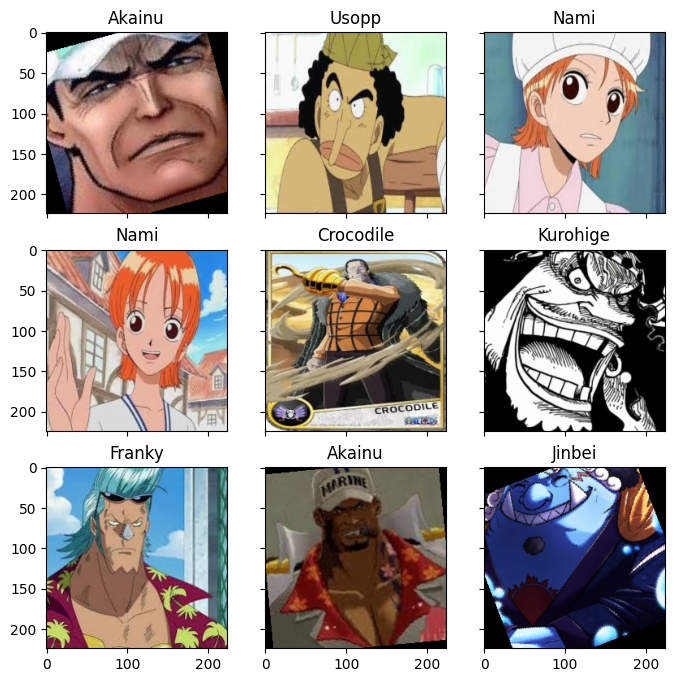

In [24]:
cur_dataset = train_dataset

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(cur_dataset)))
    im_val, label = cur_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                cur_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# training

In [12]:
avggrads_by_epochs = []

def avg_grads(model_arg):
  '''возврщает словарь вида {'название_слоя' : ср_знач_град-та_на_этом_слое} нде'''
  layer_grad_norms = {}

  for name, param in model_arg.named_parameters():
      if param.grad is not None:
          layer = name.split('.')[0]  # например, 'conv1', 'fc2'
          grad_norm = param.grad.norm().item()
          if layer not in layer_grad_norms:
              layer_grad_norms[layer] = []
          layer_grad_norms[layer].append(grad_norm)

  for k, v in layer_grad_norms.items():
    layer_grad_norms[k] = float(np.mean(v)) # вместо массива весов на слове k записываем среднее по этому массиву

  return layer_grad_norms


grads_per_epoch = []

In [13]:
def fit_epoch(model, train_dataloader, criterion, optimizer):
    '''цикл одной эпохи на train'''
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    grads_in_epoch = {}  # словарь для накопления норм градиентов по слоям

    for inputs, labels in train_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()


        # собираем градиенты этого батча
        batch_grads = avg_grads(model)

        # накапливаем градиенты по слоям
        for layer, grad_norm in batch_grads.items():
            if layer not in grads_in_epoch:
                grads_in_epoch[layer] = []
            grads_in_epoch[layer].append(grad_norm)


        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)


    # усреднение по батчам для каждого слоя
    avg_epoch_grads = {layer: float(np.mean(grads)) for layer, grads in grads_in_epoch.items()}
    avggrads_by_epochs.append(avg_epoch_grads)  # глобальный список для хранения


    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
def eval_epoch(model, val_loader, criterion):
    '''цикл одной эпохи на val'''
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [15]:
import os
import glob

# проверка на существование
os.makedirs("/content/drive/MyDrive/2 семак/нейронки/курсач/checkpoints", exist_ok=True)

# очистка папки от старых чекпойнтов
checkpoint_dir = "/content/drive/MyDrive/2 семак/нейронки/курсач/checkpoints"
for file in glob.glob(os.path.join(checkpoint_dir, "model_epoch_*.pt")):
    os.remove(file)


avggrads_by_epochs = []  # обязательно обнуляй при каждом новом запуске

In [16]:
def train(train_dataloader, val_files, model, epochs, batch_size):
    '''внешний цикл для всех эпох'''
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        if L2_REG == True:
            opt = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        else:
            opt = torch.optim.AdamW(model.parameters(), lr=0.001)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=3, verbose=True)

        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_dataloader, criterion, opt)
            # print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)

            history.append((train_loss, train_acc, val_loss, val_acc))

            scheduler.step(val_loss)

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            if epoch >= EPOCHS_FOR_TESTING[0] and epoch <= EPOCHS_FOR_TESTING[1]:
              model_path = f"/content/drive/MyDrive/2 семак/нейронки/курсач/checkpoints/model_epoch_{epoch}.pt"
              torch.save(model.state_dict(), model_path)

    return history

## SimpleCNN




In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        def my_conv(in_chan, out_chan):
          layers = [nn.Conv2d(in_chan, out_chan, kernel_size=3)]
          if batch_normalization == True:
              layers.append(nn.BatchNorm2d(out_chan))
          layers.append(nn.ReLU())
          layers.append(nn.MaxPool2d(kernel_size=2))
          return nn.Sequential(*layers)

        self.conv1 = my_conv(3, 16)
        #    Conv2d: 224 -> 222
        # MaxPool2d: 222 -> 111

        self.conv2 = my_conv(16, 32)
        #    Conv2d: 111 -> 109
        # MaxPool2d: 109 ->  54
        self.conv3 = my_conv(32, 64)
        #    Conv2d:  54 ->  52
        # MaxPool2d:  52 ->  26

        # после conv3, выходной размер: [batch_size, 64, 26, 26]
        # Flatten: 64 * 26 * 26 = 43264

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64 * 26 * 26, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=DROPOUT_PERC)
        )

        self.fc2 = nn.Linear(in_features=512, out_features=n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(x.size(0), -1)  # выпрямление перед полносвязной

        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [18]:
n_classes = len(np.unique(val_labels))
model = SimpleCNN(n_classes)
model = model.to(DEVICE)
simple_cnn = model

## history = ..

In [19]:
history = train(train_dataloader, val_files, model=simple_cnn, epochs=EPOCHS_COUNT, batch_size=batch_size)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
epoch:   0%|          | 0/25 [06:49<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
# лоссы
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
avggrads_by_epochs

# testing

In [21]:
# 'SoftMax'
def unstable_softmax(x, dim=-1):
    exp_x = torch.exp(x)  # без вычитания max
    return exp_x / exp_x.sum(dim=dim, keepdim=True)

# 'SparseMax'
def sparsemax(logits, dim=-1):
    logits = logits - logits.max(dim=dim, keepdim=True).values  # улучшение численной стабильности
    sorted_logits, _ = torch.sort(logits, descending=True, dim=dim)
    cumsum_logits = torch.cumsum(sorted_logits, dim)
    ks = torch.arange(1, logits.size(dim) + 1).view(
        [1] * (logits.dim() - 1) + [-1]
    ).to(logits)
    bound = 1 + ks * sorted_logits > cumsum_logits
    k = bound.sum(dim=dim, keepdim=True)
    tau = (cumsum_logits.gather(dim, k - 1) - 1) / k
    return torch.clamp(logits - tau, min=0.0)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание для одного изображения"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        if PROB_FUNC == 'SoftMax':
            probs = unstable_softmax(logit, dim=-1).numpy()
        elif PROB_FUNC == 'SparseMax':
            probs = sparsemax(logit, dim=-1).numpy()
        else:  # StableMax
            probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

## Acc и F1

In [ ]:
# ❗️❗️❗️ НЕ ВЫПОЛНЯТЬ без history = ❗️❗️❗️

for cur_epoch in range(EPOCHS_FOR_TESTING[0], EPOCHS_FOR_TESTING[1] + 1):
    # Загрузка модели
    epoch_for_testing = cur_epoch
    model.load_state_dict(torch.load(
        f"/content/drive/MyDrive/2 семак/нейронки/курсач/checkpoints/model_epoch_{epoch_for_testing}.pt"))
    model = model.to(DEVICE)
    model.eval()

    y_true = []
    y_pred = []

    # Прогон по всему test_dataset
    for i in range(len(test_dataset)):
        img, true_label = test_dataset[i]
        probs = predict_one_sample(model, img.unsqueeze(0))
        pred_label = np.argmax(probs, axis=-1)[0]

        y_true.append(true_label)
        y_pred.append(pred_label)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='micro')

    print(f'epoch {cur_epoch}:')
    print(f'\tAcc : {acc:.4f}')
    print(f'\t F1 : {f1:.4f}')
    print()

## сетка test-картинок

In [ ]:
# откат до лучшей модели

# BEST_EPOCH = 15
# model.load_state_dict(torch.load(
#     f"/content/drive/MyDrive/2 семак/нейронки/курсач/checkpoints/model_epoch_{BEST_EPOCH}.pt"))
model.load_state_dict(torch.load(
    f"/content/drive/MyDrive/2 семак/нейронки/курсач/checkpoints/BEST_(ep15_noBN_0.6691).pt"))
model = model.to(DEVICE)
model.eval()


import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_index = int(np.random.uniform(0, len(test_dataset)))
    im_test = test_dataset[random_index][0]  # без label
    target = label_encoder.inverse_transform([test_dataset[random_index][1]])[0]

    imshow(im_test.data.cpu(), title=target, plt_ax=fig_x)

    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")

    prob_pred = predict_one_sample(simple_cnn, im_test.unsqueeze(0))
    top3_indices = np.argsort(prob_pred[0])[::-1][:3]
    top3_probs = prob_pred[0][top3_indices] * 100
    top3_labels = [label_encoder.classes_[i] for i in top3_indices]
    top3_labels_wrapped = [lbl[:len(lbl)//2] + '\n' + lbl[len(lbl)//2:] if len(lbl) > 10 else lbl for lbl in top3_labels]
    predicted_text = "\n".join([f"{lbl} : {prob:.0f}%" for lbl, prob in zip(top3_labels_wrapped, top3_probs)])

    fig_x.text(1, 59, predicted_text, horizontalalignment='left',
               fontproperties=font, verticalalignment='top',
               fontsize=8, color='black', fontweight='bold')


## SoftMax - SparseMax

In [22]:
import matplotlib.pyplot as plt
import numpy as np

logits_dict = {}  # словарь {номер картинки: [ее логиты]}

model.eval()
with torch.no_grad():
    for i in range(len(test_dataset)):
        img, _ = test_dataset[i]
        img = img.unsqueeze(0).to(DEVICE)
        logit = model(img).squeeze(0).cpu().numpy()  # [18]
        logits_dict[i] = logit.tolist()

# Визуализация
plt.figure(figsize=(12, len(logits_dict) * 0.3))  # высокий график

for idx, logits in logits_dict.items():
    logits = np.array(logits)
    y_vals = np.full_like(logits, idx)

    # Индексы топ-3 логитов
    top3_idx = logits.argsort()[-3:]

    # Маски
    mask_top3 = np.zeros_like(logits, dtype=bool)
    mask_top3[top3_idx] = True

    # Рисуем: остальные — серые, топ-3 — зелёные
    plt.scatter(logits[~mask_top3], y_vals[~mask_top3], s=10, color='gray', alpha=0.5)
    plt.scatter(logits[mask_top3], y_vals[mask_top3], s=30, color='green', alpha=0.9)

plt.xlim(-25, 25)
plt.ylim(-1, len(logits_dict))
plt.xlabel("Logit values")
plt.ylabel("Sample index")
plt.title("Логиты для всех картинок тестового датасета")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

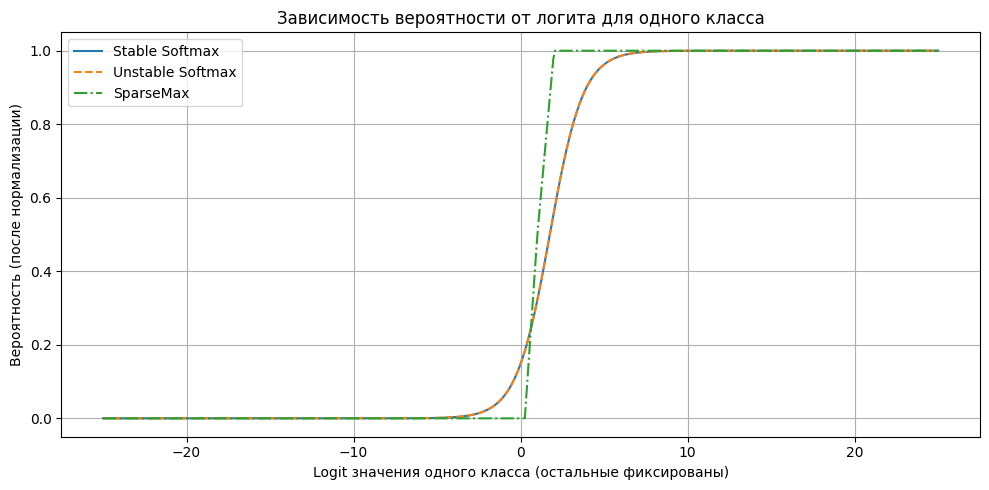

In [23]:
# Подготовка входа: логиты из 5 классов, где один варьируется от -25 до 25
x_range = torch.linspace(-25, 25, 500)
other_logits = torch.tensor([0.0, 1.0, -1.0, 0.5])  # фиксированные значения
all_logits = torch.stack([torch.cat([torch.tensor([v]), other_logits]) for v in x_range])

# Вычисление вероятностей
unstable = unstable_softmax(all_logits, dim=1)[:, 0].numpy()
stable = torch.nn.functional.softmax(all_logits, dim=1)[:, 0].numpy()
sparse = sparsemax(all_logits, dim=1)[:, 0].numpy()

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(x_range.numpy(), stable, label='Stable Softmax', linestyle='-')
plt.plot(x_range.numpy(), unstable, label='Unstable Softmax', linestyle='--')
plt.plot(x_range.numpy(), sparse, label='SparseMax', linestyle='-.')

plt.title("Зависимость вероятности от логита для одного класса")
plt.xlabel("Logit значения одного класса (остальные фиксированы)")
plt.ylabel("Вероятность (после нормализации)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## градиентов визуализация

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ваш список словарей (пример)
data = [{'conv1': 0.8974785817661352,
  'conv2': 1.3011058818354655,
  'conv3': 1.7611424194568872,
  'fc1': 0.36997845868345786,
  'fc2': 1.794949825875964},
 {'conv1': 1.9181495966629747,
  'conv2': 1.9587736947039154,
  'conv3': 2.1326957694226247,
  'fc1': 0.3794619710258911,
  'fc2': 2.040640667469406},
 {'conv1': 2.111214204434237,
  'conv2': 1.9680670364502748,
  'conv3': 2.053103175997003,
  'fc1': 0.4231378834271815,
  'fc2': 2.080980129974203},
 {'conv1': 2.1491322275136877,
  'conv2': 1.8699712850199155,
  'conv3': 1.9974960726828663,
  'fc1': 0.48285115198260803,
  'fc2': 2.2157484860462278},
 {'conv1': 2.192388257548853,
  'conv2': 1.7918024520201186,
  'conv3': 1.9547307630258104,
  'fc1': 0.47988534826739615,
  'fc2': 2.053981187553402},
 {'conv1': 2.2134434880197413,
  'conv2': 1.7325911993629362,
  'conv3': 1.878524023193889,
  'fc1': 0.48526151773114146,
  'fc2': 1.9876490768982222},
 {'conv1': 2.026053867457103,
  'conv2': 1.579818392046756,
  'conv3': 1.667941948158975,
  'fc1': 0.4591719713062048,
  'fc2': 1.8010571992333315},
 {'conv1': 2.055606130487714,
  'conv2': 1.5610220949708318,
  'conv3': 1.650519976038143,
  'fc1': 0.46703975674542,
  'fc2': 1.8470531759863615},
 {'conv1': 2.0203053281625354,
  'conv2': 1.5266764976221359,
  'conv3': 1.6101671437635743,
  'fc1': 0.44653506710142626,
  'fc2': 1.6933198049093134},
 {'conv1': 2.4963428346565895,
  'conv2': 1.7598614648350177,
  'conv3': 1.8057056940132123,
  'fc1': 0.4629965506356918,
  'fc2': 1.7697107980907694},
 {'conv1': 1.8078542253676733,
  'conv2': 1.3826052682485683,
  'conv3': 1.4213352936085748,
  'fc1': 0.4125168234841224,
  'fc2': 1.5094482380599699},
 {'conv1': 1.433556488857953,
  'conv2': 1.0676902075372408,
  'conv3': 1.1568525387602715,
  'fc1': 0.36528468917572493,
  'fc2': 1.3178001870358351},
 {'conv1': 1.5973180417725645,
  'conv2': 1.1699927466367286,
  'conv3': 1.2404333315561153,
  'fc1': 0.37882844818915967,
  'fc2': 1.4084779476586935},
 {'conv1': 1.5669368096153062,
  'conv2': 1.1686019367578389,
  'conv3': 1.229843142962346,
  'fc1': 0.37740163868250315,
  'fc2': 1.3947207353312088},
 {'conv1': 1.53664477900002,
  'conv2': 1.1766684865436168,
  'conv3': 1.2165626046659161,
  'fc1': 0.37724067940251,
  'fc2': 1.3887642676380685},
 {'conv1': 1.5106123523112456,
  'conv2': 1.1251340605364255,
  'conv3': 1.1927407737707068,
  'fc1': 0.3674354045623285,
  'fc2': 1.351677321120411},
 {'conv1': 1.5290882071148764,
  'conv2': 1.1190748753860318,
  'conv3': 1.1934612731626428,
  'fc1': 0.3725852321196302,
  'fc2': 1.3857175539664788},
 {'conv1': 1.4747808281035146,
  'conv2': 1.1197262944802184,
  'conv3': 1.1675417642880437,
  'fc1': 0.365948778717133,
  'fc2': 1.3502814316853562},
 {'conv1': 1.4136253279045317,
  'conv2': 1.0875402982546691,
  'conv3': 1.1684614232986983,
  'fc1': 0.3598498898780436,
  'fc2': 1.3205131151716287},
 {'conv1': 1.4193551736188184,
  'conv2': 1.060060537693932,
  'conv3': 1.1217247066568323,
  'fc1': 0.3564260042039008,
  'fc2': 1.2975902741990204},
 {'conv1': 1.5384600884938167,
  'conv2': 1.1143713880993107,
  'conv3': 1.1785893443217672,
  'fc1': 0.3756132651966042,
  'fc2': 1.3430654636035713},
 {'conv1': 1.591292357700734,
  'conv2': 1.1691042768763253,
  'conv3': 1.225104755944818,
  'fc1': 0.38322845697431523,
  'fc2': 1.4300479754588447},
 {'conv1': 1.5719393039453615,
  'conv2': 1.188875521927432,
  'conv3': 1.2353386278578475,
  'fc1': 0.383940886706828,
  'fc2': 1.4065525145384203},
 {'conv1': 1.5125319004127402,
  'conv2': 1.111827562174594,
  'conv3': 1.1673968724500776,
  'fc1': 0.372386918725493,
  'fc2': 1.364978319190391},
 {'conv1': 1.5247954074845098,
  'conv2': 1.159632363905516,
  'conv3': 1.2169631921398407,
  'fc1': 0.3788375338387869,
  'fc2': 1.3975024654220114}]

# Создаём DataFrame: строки — эпохи, столбцы — слои
df = pd.DataFrame(data)

# Убедимся, что столбцы идут в правильном порядке
layer_order = ['conv1', 'conv2', 'conv3', 'fc1', 'fc2']
df = df[layer_order]

# Добавим колонку "Epoch" (для yticklabels)
df['Epoch'] = range(1, len(df) + 1)

# Рисуем тепловую карту: без реверса, всё в прямом порядке
plt.figure(figsize=(10, 12))
sns.heatmap(df[layer_order],
            xticklabels=layer_order,
            yticklabels=df['Epoch'],       # эпохи от 1 до N — сверху вниз
            cmap="YlOrRd", annot=True, fmt=".2f",
            cbar_kws={'label': 'Gradient Norm'},
            vmin=0, vmax=4)

plt.xlabel("Layer")
plt.ylabel("Epoch")
plt.title("Gradient Norms per Layer across Epochs (Without BatchNorm)")
plt.tight_layout()
plt.show()


## кастомная фотка

In [ ]:
from torchvision import transforms
import os

drive.mount('/content/drive/')


# Путь к папке на диске с картинками
image_folder = "/content/drive/MyDrive/2 семак/нейронки/курсач/картинка из гугла"
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

# Выбор случайной картинки
random_file = np.random.choice(image_files)
image_path = os.path.join(image_folder, random_file)

# Предобработка картинки
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_pil = Image.open(image_path).convert("RGB")
img_tensor = transform(img_pil).unsqueeze(0)  # [1, 3, 96, 96]


##############################################################


# Предсказание
prob_pred = predict_one_sample(simple_cnn, img_tensor)
top3_indices = np.argsort(prob_pred[0])[::-1][:3]
top3_probs = prob_pred[0][top3_indices] * 100
top3_labels = [label_encoder.classes_[i] for i in top3_indices]
top3_labels_wrapped = [lbl[:len(lbl)//2] + '\n' + lbl[len(lbl)//2:] if len(lbl) > 10 else lbl for lbl in top3_labels]
predicted_text = "\n".join([f"{lbl} : {prob:.0f}%" for lbl, prob in zip(top3_labels_wrapped, top3_probs)])

# Отрисовка
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(np.transpose(img_tensor.squeeze(0).cpu().numpy(), (1, 2, 0)))
ax.axis("off")

# Белый прямоугольник и текст
ax.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
font0 = FontProperties()
font = font0.copy()
font.set_family("fantasy")

ax.text(1, 59, predicted_text, horizontalalignment='left',
        fontproperties=font, verticalalignment='top',
        fontsize=8, color='black', fontweight='bold')

print(prob_pred)

plt.title(random_file)
plt.show()